
Processing pmed_scrap\pmed1.txt | |V|: 100 | Arestas: 200 | k: 5
Testing raio = 143.0 (mid index: 142)
Status for raio 143.0: Optimal
Testing raio = 71.0 (mid index: 70)
Status for raio 71.0: Infeasible
Testing raio = 107.0 (mid index: 106)
Status for raio 107.0: Infeasible
Testing raio = 125.0 (mid index: 124)
Status for raio 125.0: Infeasible
Testing raio = 134.0 (mid index: 133)
Status for raio 134.0: Optimal
Testing raio = 129.0 (mid index: 128)
Status for raio 129.0: Optimal
Testing raio = 127.0 (mid index: 126)
Status for raio 127.0: Optimal
Testing raio = 126.0 (mid index: 125)
Status for raio 126.0: Infeasible
Exact Method: Raio Preciso com PLI = 127.0 | Time: 12.31 seconds
Initial center: 82
Selected center: 66 at distance 283.0
Selected center: 77 at distance 265.0
Selected center: 70 at distance 231.0
Selected center: 89 at distance 207.0
Approximate Method: Raio Aproximado = 192.0 | Time: 0.01 seconds

Processing pmed_scrap\pmed2.txt | |V|: 100 | Arestas: 200 | k: 10
Testi

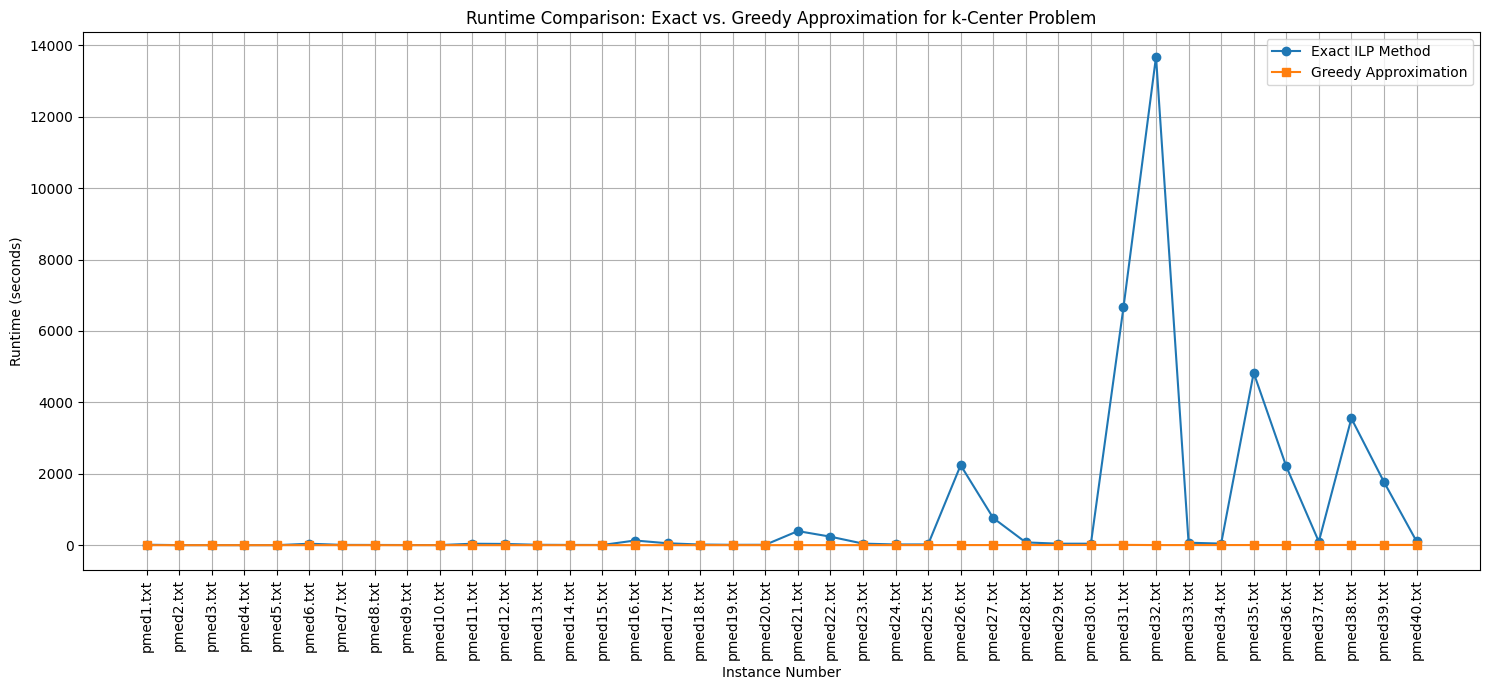

In [ ]:
import networkx as nx
from pulp import LpMinimize, LpProblem, LpVariable, lpSum, LpStatus
import os
import time
import matplotlib.pyplot as plt
import random

# Função para ler o arquivo e construir o grafo
def carregar_grafo(filepath):
    G = nx.Graph()
    with open(filepath, 'r') as file:
        primeira_linha = file.readline().strip().split()
        if len(primeira_linha) < 3:
            raise ValueError("O arquivo de entrada deve conter pelo menos três inteiros na primeira linha: m n k")
        num_vertices = int(primeira_linha[0])
        num_arestas = int(primeira_linha[1])
        k = int(primeira_linha[2])
        
        # Adiciona as arestas e seus pesos no grafo
        for _ in range(num_arestas):
            line = file.readline()
            if not line:
                raise ValueError(f"Esperado {num_arestas} arestas, mas o arquivo terminou inesperadamente.")
            v1, v2, peso = map(float, line.strip().split())
            G.add_edge(int(v1), int(v2), weight=peso)
    
    return G, num_vertices, num_arestas, k

# Resolver o problema usando Programação Linear Inteira (PLI)
def k_centros_exato_pli(G, k):
    # Calcula todas as distâncias entre os pares de vértices
    distancias = dict(nx.all_pairs_dijkstra_path_length(G, weight='weight'))
    
    # Obtém todas as distâncias únicas
    unique_distances = set()
    for source in distancias:
        for target, dist in distancias[source].items():
            unique_distances.add(dist)
    
    sorted_distances = sorted(unique_distances)
    
    # Busca binária para encontrar o menor raio possível
    left = 0
    right = len(sorted_distances) - 1
    melhor_raio = sorted_distances[-1]  # Inicializa com a maior distância possível
    
    while left <= right:
        mid = (left + right) // 2
        raio = sorted_distances[mid]
        print(f"Testando raio = {raio} (índice médio: {mid})")
        
        # Criação do modelo PLI
        model = LpProblem("k-Centros", LpMinimize)
        
        # Variáveis de decisão
        x = LpVariable.dicts("x", G.nodes, cat="Binary")  # 1 se i é um centro
        y = LpVariable.dicts("y", [(i, j) for i in G.nodes for j in G.nodes], cat="Binary")  # 1 se j é coberto por i
        
        # Função objetivo (não utilizada diretamente aqui)
        model += 0, "Dummy Objective"
        
        # Restrição: exatamente k centros
        model += lpSum(x[i] for i in G.nodes) == k, "Exatamente_k_centros"
        
        # Restrição: cada vértice deve ser coberto por pelo menos um centro dentro do raio
        for j in G.nodes:
            model += lpSum(y[i, j] for i in G.nodes if distancias[i][j] <= raio) >= 1, f"Cobertura_{j}"
        
        # Restrição: se j for coberto por i, então i deve ser um centro
        for i in G.nodes:
            for j in G.nodes:
                if distancias[i][j] <= raio:
                    model += y[i, j] <= x[i], f"Vinculo_{i}_{j}"
        
        # Resolver o modelo
        model.solve()
        
        # Verificar o status da solução
        status = LpStatus[model.status]
        print(f"Status para raio {raio}: {status}")
        
        if status == 'Optimal':
            # Solução viável, tenta encontrar um raio menor
            melhor_raio = raio
            right = mid - 1
        else:
            # Solução inviável, aumenta o raio
            left = mid + 1
    
    return melhor_raio

# Resolver o problema usando o Algoritmo Guloso Aproximado
def k_centros_aproximado_guloso(G, k):
    # Calcula todas as distâncias entre os pares de vértices
    distancias = dict(nx.all_pairs_dijkstra_path_length(G, weight='weight'))
    
    # Inicializa os centros escolhendo um nó aleatório
    random.seed(42)  # Para reprodução dos resultados
    first_center = random.choice(list(G.nodes))
    centers = [first_center]
    print(f"Centro inicial: {first_center}")
    
    # Iterativamente seleciona o nó mais distante dos centros atuais
    for _ in range(1, k):
        max_dist = -1
        farthest_node = None
        for node in G.nodes:
            # Calcula a menor distância entre o nó e os centros
            min_dist_to_center = min(distancias[node][center] for center in centers)
            if min_dist_to_center > max_dist:
                max_dist = min_dist_to_center
                farthest_node = node
        centers.append(farthest_node)
        print(f"Centro selecionado: {farthest_node} com distância {max_dist}")
    
    # Calcula o raio máximo (distância do nó mais distante ao centro mais próximo)
    max_radius = 0
    for node in G.nodes:
        min_dist_to_center = min(distancias[node][center] for center in centers)
        if min_dist_to_center > max_radius:
            max_radius = min_dist_to_center
    
    return max_radius, centers

def main():
    # Caminho para a pasta contendo os arquivos de entrada
    pasta_arquivos = 'pmed_scrap'
    
    # Listas para armazenar os tempos de execução
    exact_runtimes = []
    approx_runtimes = []
    instances = []
    
    # Itera sobre todos os arquivos na pasta
    for i in range(1, 41):
        filepath = os.path.join(pasta_arquivos, f'pmed{i}.txt')
        if not os.path.isfile(filepath):
            print(f"Arquivo {filepath} não existe. Pulando.")
            continue
        try:
            G, num_vertices, num_arestas, k = carregar_grafo(filepath)
            print(f"\nProcessando {filepath} | |V|: {num_vertices} | Arestas: {num_arestas} | k: {k}")
            
            # Mede o tempo do método exato
            start_time_exact = time.time()
            raio_preciso = k_centros_exato_pli(G, k)
            end_time_exact = time.time()
            runtime_exact = end_time_exact - start_time_exact
            exact_runtimes.append(runtime_exact)
            print(f"Método Exato: Raio Preciso com PLI = {raio_preciso} | Tempo: {runtime_exact:.2f} segundos")
            
            # Mede o tempo do método aproximado
            start_time_approx = time.time()
            raio_aproximado, centers = k_centros_aproximado_guloso(G, k)
            end_time_approx = time.time()
            runtime_approx = end_time_approx - start_time_approx
            approx_runtimes.append(runtime_approx)
            print(f"Método Aproximado: Raio Aproximado = {raio_aproximado} | Tempo: {runtime_approx:.2f} segundos")
            
            # Registra a instância processada
            instances.append(f'pmed{i}.txt')
            
        except Exception as e:
            print(f"Ocorreu um erro ao processar {filepath}: {e}\n")
    
    # Gera o gráfico comparativo dos tempos de execução
    if instances:
        plt.figure(figsize=(15, 7))
        x = range(1, len(instances) + 1)
        plt.plot(x, exact_runtimes, marker='o', label='Método Exato PLI')
        plt.plot(x, approx_runtimes, marker='s', label='Aproximação Gulosa')
        plt.xlabel('Número da Instância')
        plt.ylabel('Tempo de Execução (segundos)')
        plt.title('Comparação de Tempo: Método Exato vs Aproximação Gulosa para k-Centro')
        plt.xticks(x, instances, rotation=90)
        plt.legend()
        plt.tight_layout()
        plt.grid(True)
        plt.show()
    else:
        print("Nenhuma instância foi processada. Nenhum gráfico será exibido.")

if __name__ == "__main__":
    main()